In [ ]:
import torch
import numpy as np
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path_to_embeddings = "/content/drive/MyDrive/all"
indices = np.load(os.path.join(path_to_embeddings, "indicies.npy"))
titleabstracts = np.load(os.path.join(path_to_embeddings, "titleabstracts.npy"))
fulltexts = np.load(os.path.join(path_to_embeddings, "fulltext.npy"))
fulltexttruncs = np.load(os.path.join(path_to_embeddings, "fulltext_trunc.npy"))


In [ ]:
top_level = pd.read_csv("/content/drive/MyDrive/top_level_classifications.csv")
second_level = pd.read_csv("/content/drive/MyDrive/second_level_classifications.csv")
top_level["app_ref_doc_number"] = [str(x) for x in top_level["app_ref_doc_number"]]
second_level["app_ref_doc_number"] = [str(x) for x in second_level["app_ref_doc_number"]]
top_level.set_index("app_ref_doc_number", inplace = True)
second_level.set_index("app_ref_doc_number", inplace = True)

In [ ]:
# Ensure you're using a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume `embeddings` is your (29500, 1024) NumPy array
embeddings = torch.tensor(titleabstracts, dtype=torch.float32).to(device)

# Step 1: Normalize the embeddings
norms = embeddings.norm(dim=1, keepdim=True)
normalized_embeddings = embeddings / norms

# Step 2: Compute the cosine similarity matrix
cosine_similarity_matrix = torch.mm(normalized_embeddings, normalized_embeddings.T)

# Optional: Move the result back to the CPU if needed
cosine_similarity_matrix = cosine_similarity_matrix.cpu().numpy()

print("Cosine similarity matrix shape:", cosine_similarity_matrix.shape)

Cosine similarity matrix shape: (29526, 29526)


In [ ]:
def other_index_gen(patent_index):
  index_row = top_level.loc[patent_index]
  columns = index_row[index_row == 1].index.tolist()
  # Get all rows that have 1 in in the same columns
  rows = top_level[top_level[columns].eq(1).any(axis = 1)]
  return set(rows.index)


In [ ]:
all_ordered = []
all_ind = []
count = 0
for ind, row in zip(indices, cosine_similarity_matrix):
  count += 1
  if count%100 ==0:
    print(count)
  combined = np.stack((indices, row), axis = 1)
  sorted_data = combined[np.argsort(combined[:,1])]
  ordered = sorted_data[:,0]
  try:
    other_indices = other_index_gen(ind)
    positions = [1 if x in other_indices else 0 for x in ordered]
    all_ordered.append(sum(positions[15000:])/sum(positions))
    all_ind.append(ind)
  except:
    print(f"missing index {ind}")


100
200
300
400
500
600
700
800
900
missing index 17491034
1000
1100
missing index 17300793
missing index 17300819
1200
1300
1400
1500
1600
missing index 17300106
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
missing index 17474983
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
missing index 18084500
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
missing index 18115853
missing index 18115863
9700
9800
missing index 18075956
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
missing index 18105351
11100
11200
11300
11400
11500
missing index 18186165
11600
11700
11800
missing index 18070649
missing index 18070652
missing index 18070658
missing index 18070668
11900
missing index 18101417
missing index 18102970
120

In [ ]:
all_ordered = np.load("/content/drive/MyDrive/all_ordered_TA.npy")

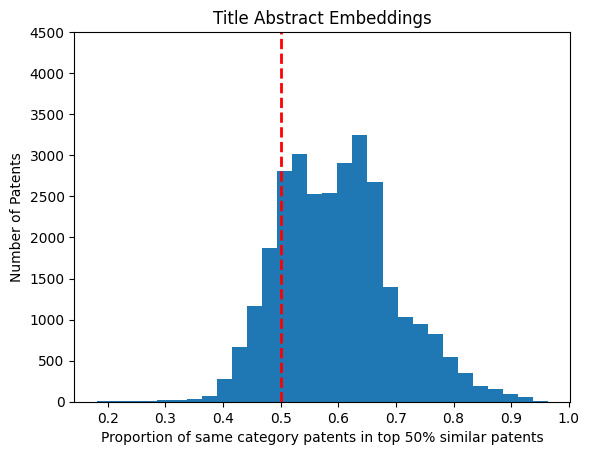

In [ ]:
import matplotlib.pyplot as plt
plt.hist(all_ordered, bins = 30)
plt.title("Title Abstract Embeddings")
plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500])
plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='x=0.5')
plt.ylabel("Number of Patents")
plt.xlabel("Proportion of same category patents in top 50% similar patents")
plt.show()

In [ ]:
# Average Proportion of same category patents in top 50% similar patents
print(sum(all_ordered)/len(all_ordered))

0.5987812538282272


In [ ]:
# Proportion of patents with over 50% of same category patents in top 50% of similarity
print(np.sum(np.array(all_ordered)>0.5)/len(all_ordered))

0.8412903225806452


In [ ]:
np.save("/content/drive/MyDrive/all_ordered_TA.npy", np.array(all_ordered))
np.save("/content/drive/MyDrive/all_ind_TA.npy", np.array(all_ind))

In [ ]:
all_accuracies = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in range(2,11):
  # Assume `embeddings` is your (29500, 1024) NumPy array
  accuracy = []
  normalized_titleabstracts = titleabstracts / np.linalg.norm(titleabstracts)
  normalized_fulltexts = fulltexts / np.linalg.norm(fulltexts)
  embed = np.hstack((normalized_titleabstracts, normalized_fulltexts*i))
  embeddings = torch.tensor(embed, dtype=torch.float32).to(device)

  # Step 1: Normalize the embeddings
  norms = embeddings.norm(dim=1, keepdim=True)
  normalized_embeddings = embeddings / norms

  # Step 2: Compute the cosine similarity matrix
  cosine_similarity_matrix = torch.mm(normalized_embeddings, normalized_embeddings.T)

  # Step 3: Move the result back to the CPU if needed
  cosine_similarity_matrix = cosine_similarity_matrix.cpu().numpy()
  torch.cuda.empty_cache()  # Clear unused GPU memory
  print("Cosine similarity matrix shape:", cosine_similarity_matrix.shape)

  accuracy = []
  count = 0
  for ind, row in zip(indices, cosine_similarity_matrix):
    count += 1
    if count%1000 ==0:
      print(count)
    combined = np.stack((indices, row), axis = 1)
    sorted_data = combined[np.argsort(combined[:,1])]
    ordered = sorted_data[:,0]
    try:
      other_indices = other_index_gen(ind)
      positions = [1 if x in other_indices else 0 for x in ordered]
      accuracy.append(sum(positions[15000:])/sum(positions))
    except:
      print(f"missing index {ind}")
  np.save(f"/content/drive/MyDrive/FTtoTA_{i}.npy", np.array(accuracy))


Cosine similarity matrix shape: (29526, 29526)
missing index 17491034
1000
missing index 17300793
missing index 17300819
missing index 17300106
2000
3000
4000
missing index 17474983
5000
6000
7000
missing index 18084500
8000
9000
missing index 18115853
missing index 18115863
missing index 18075956
10000
11000
missing index 18105351
missing index 18186165
missing index 18070649
missing index 18070652
missing index 18070658
missing index 18070668
missing index 18101417
missing index 18102970
12000
13000
missing index 18090867
missing index 17991529
missing index 17992271
missing index 17992289
missing index 17992313
missing index 18095722
14000
missing index 18088906
missing index 18088916
missing index 18088926
15000
missing index 17961662
missing index 17963246
missing index 17968087
missing index 17968097
missing index 17961712
missing index 17961727
missing index 17961745
missing index 17958467
missing index 17958468
missing index 17882849
missing index 17882861
missing index 1788286